# Random Forest Regression
This notebook builds upon the previous ones, however, this time fitting a random forest regression model to predict instead. We will also use it to evaluate our feature importance. We will also use a little more feature scaling this time around for more improvement. 


In [1]:
import numpy as np 
import pandas as pd
import sqlite3 
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
import math
%matplotlib inline 
np.random.seed(42)

raw_folder = '/users/csinclair/SF_Parking/data/raw/'
proc_folder = '/users/csinclair/SF_Parking/data/processed/'
image_folder = '/users/csinclair/SF_Parking/reports/figures/rfr/'

mp.rcParams

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
with open(proc_folder + 'streets.pickle', 'rb') as f:
    df = pickle.load(f)
df.set_index('lineid', inplace = True)

''

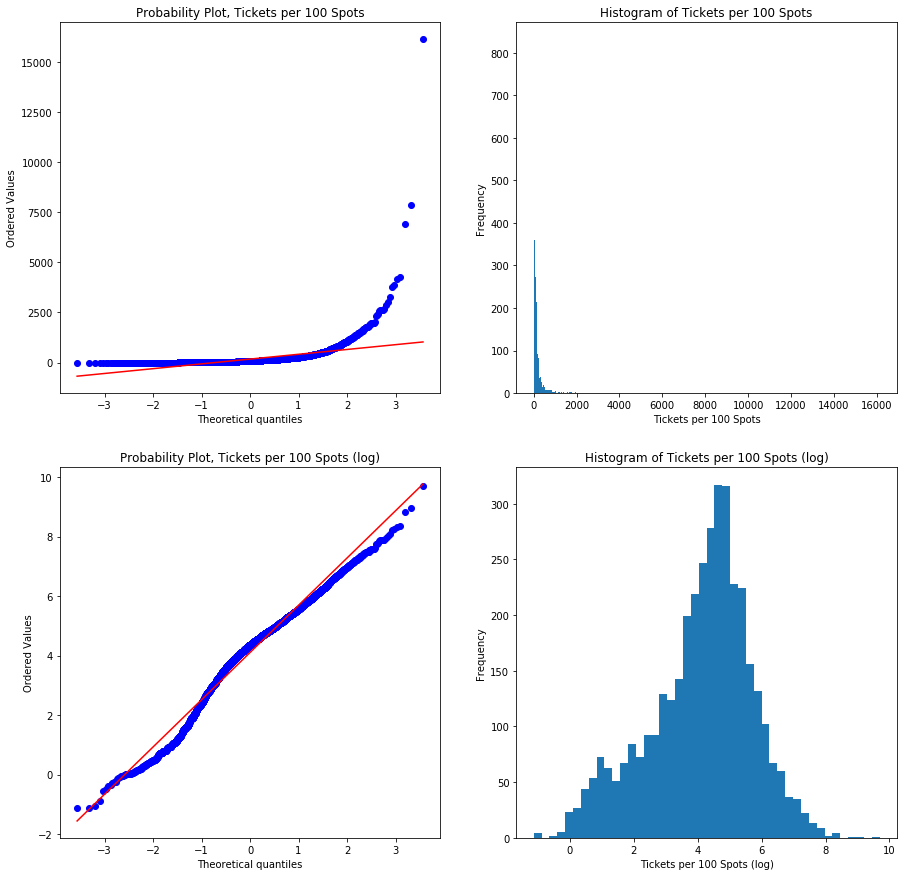

In [3]:
# look at probability plot, it may make sense to log fit the number of tickets this time around 
fig, ax = plt.subplots(2,2, figsize = (15, 15))
stats.probplot(df['tickperspot'], plot=ax[0,0])
ax[0,0].set_title('Probability Plot, Tickets per 100 Spots')
ax[0,1].hist(df['tickperspot'], bins = 'auto')
ax[0,1].set_title('Histogram of Tickets per 100 Spots')
ax[0,1].set_xlabel('Tickets per 100 Spots')
ax[0,1].set_ylabel('Frequency')
stats.probplot(np.log(df['tickperspot']), plot=ax[1,0])
ax[1,0].set_title('Probability Plot, Tickets per 100 Spots (log)')
ax[1,1].hist(np.log(df['tickperspot']), bins = 'auto')
ax[1,1].set_title('Histogram of Tickets per 100 Spots (log)')
ax[1,1].set_xlabel('Tickets per 100 Spots (log)')
ax[1,1].set_ylabel('Frequency')
fig.savefig(image_folder + 'logfitvar.png')
;

In [4]:
predictors = ['distance', 'total_ea', 'vvol_carea', 'vvol_trkea', 'vvol_busea', 'speed_ea', 'oneway', 'parkpermile' ]
Xtr, Xts, Ytr, Yts = train_test_split( df[predictors], np.log(df['tickperspot']), test_size = .15)

In [5]:
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
dtr = DecisionTreeRegressor()
param_grid = {'min_samples_leaf':np.arange(10,300,10), 'max_depth': np.arange(1,15) }
scoring = make_scorer(r2_score)
reg = GridSearchCV(dtr, param_grid, cv = 4, return_train_score = True, scoring = scoring)
reg.fit(Xtr, Ytr)
pd.DataFrame(reg.cv_results_).sort_values(by = 'mean_test_score', ascending = False)[['params','mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
134,"{'max_depth': 5, 'min_samples_leaf': 190}",0.085677,0.065851
337,"{'max_depth': 12, 'min_samples_leaf': 190}",0.089826,0.065579
279,"{'max_depth': 10, 'min_samples_leaf': 190}",0.089826,0.065579
221,"{'max_depth': 8, 'min_samples_leaf': 190}",0.089826,0.065579
395,"{'max_depth': 14, 'min_samples_leaf': 190}",0.089826,0.065579


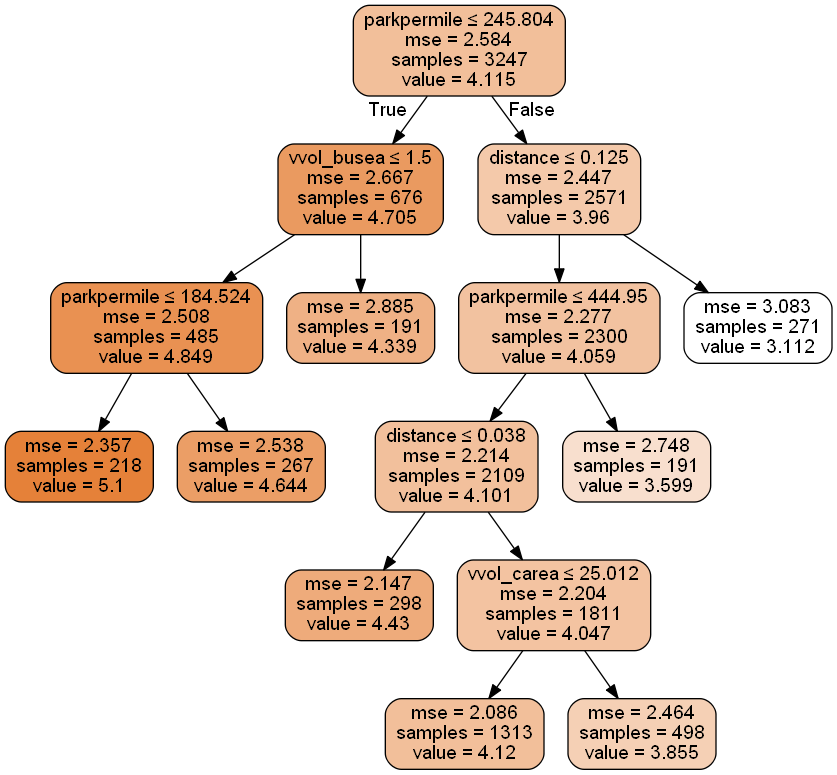

In [6]:
from IPython.display import Image  
from sklearn.tree import export_graphviz

dtr = DecisionTreeRegressor(min_samples_leaf = 190, max_depth = 5)
dtr.fit(Xtr, Ytr)

export_graphviz(dtr, out_file='InititalTree.dot', 
                filled=True, rounded=True,
                feature_names = predictors, 
                special_characters=True)

!dot -Tpng InititalTree.dot -o initialtree.png

from IPython.display import Image
Image(filename='initialtree.png') 

In [7]:
Ypr = dtr.predict(Xts)
print(((Ypr - Yts)**2).mean(axis = None))
print(((Ypr - Yts)**2).mean(axis = None) / Yts.mean())
print(r2_score(Yts, Ypr))

2.5291911254254202
0.6245670628061528
0.013561427435176743


In [8]:
for f in range(len(predictors)):
    print('Feature ' + predictors[f] + ' had importance of ' + str(dtr.feature_importances_[f]) )

Feature distance had importance of 0.3739762845911344
Feature total_ea had importance of 0.0
Feature vvol_carea had importance of 0.03701659436146355
Feature vvol_trkea had importance of 0.0
Feature vvol_busea had importance of 0.052298062833650405
Feature speed_ea had importance of 0.0
Feature oneway had importance of 0.0
Feature parkpermile had importance of 0.5367090582137516


In [9]:
print(dtr.tree_.feature)
print(dtr.tree_.children_left) #array of left children
print(dtr.tree_.value.ravel())
print(dtr.tree_.children_right)

[ 7  4  7 -2 -2 -2  0  7  0 -2  2 -2 -2 -2 -2]
[ 1  2  3 -1 -1 -1  7  8  9 -1 11 -1 -1 -1 -1]
[4.11468871 4.7047616  4.84896811 5.10030042 4.64376045 4.33858277
 3.95953924 4.05940814 4.10105999 4.4303471  4.04687581 4.11961876
 3.85508566 3.59949317 3.11194344]
[ 6  5  4 -1 -1 -1 14 13 10 -1 12 -1 -1 -1 -1]


In [10]:
#create a loop that will go through all the decisions and measure the decrease/increase in average
def return_change(dtr):
    featuredict = {}
    for i, t in enumerate(dtr.tree_.feature):
        if t > -2:
            curavg = dtr.tree_.value[i]    
            changeleft = dtr.tree_.value[dtr.tree_.children_left[i]] / curavg
            changeright = dtr.tree_.value[dtr.tree_.children_right[i]] /curavg
            if t in featuredict.keys():
                featuredict[t] = np.append(featuredict[t],(changeleft / changeright))
            else:
                featuredict[t] = (changeleft / changeright)
    return featuredict

In [11]:
featuredict = return_change(dtr)

In [12]:
def create_df(featuredict):
    totaldict = {}
    totaldict['feature'] = []
    totaldict['importance'] = []
    totaldict['decrease'] = []

    for i in featuredict.keys():
        print("{} had an importance of {:.2f} and a mean avg decrease of {:.2f} ".format(predictors[i], dtr.feature_importances_[i] ,featuredict[i].mean() ))
        totaldict['feature'].append(predictors[i])
        totaldict['importance'].append(dtr.feature_importances_[i])
        totaldict['decrease'].append(featuredict[i].mean())
        
    return pd.DataFrame.from_dict(totaldict).sort_values(by = 'importance', ascending = False)

In [13]:
featdf = create_df(featuredict)
featdf['decrease'] = featdf['decrease'] - 1

parkpermile had an importance of 0.54 and a mean avg decrease of 1.14 
vvol_busea had an importance of 0.05 and a mean avg decrease of 1.12 
distance had an importance of 0.37 and a mean avg decrease of 1.20 
vvol_carea had an importance of 0.04 and a mean avg decrease of 1.07 


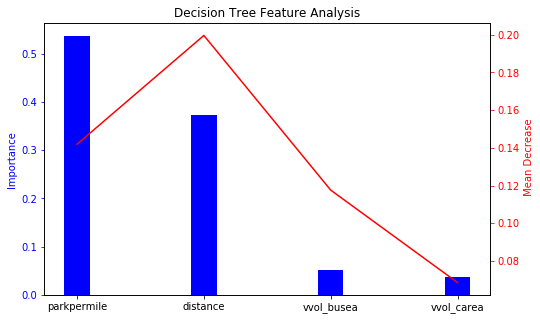

In [17]:
def plot_features(feat_df):
    plt.figure(figsize = ( featdf.shape[0] * 2, math.ceil(featdf.shape[0] / 5) * 5) )
    ax1 = plt.subplot(111)
    ax1.bar(featdf['feature'], featdf['importance'], width=0.2, color='b',align='center')
    ax1.set_ylabel('Importance', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(featdf['feature'], featdf['decrease'] , color = 'r')
    ax2.set_ylabel(' Mean Decrease', color='r')
    ax2.tick_params('y', colors='r')
    if featdf['decrease'].min() < 0:
        ax2.axhline(y = 0, linestyle = '--', color = 'gray')
    ax1.set_title('Decision Tree Feature Analysis')
    return ax1

ax = plot_features(featdf)    
plt.savefig('basictreefeature.png')

In [16]:
nhoods = pd.get_dummies(df['nhood'])
Xtr = Xtr.join(nhoods)
reg = GridSearchCV(dtr, param_grid, cv = 5, return_train_score = True, scoring = scoring)
reg.fit(Xtr, Ytr)
pd.DataFrame(reg.cv_results_).sort_values(by = 'mean_test_score', ascending = False)[['params','mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
292,"{'max_depth': 11, 'min_samples_leaf': 30}",0.183864,0.086500
321,"{'max_depth': 12, 'min_samples_leaf': 30}",0.191901,0.086229
350,"{'max_depth': 13, 'min_samples_leaf': 30}",0.202285,0.084782
261,"{'max_depth': 10, 'min_samples_leaf': 10}",0.229188,0.082988
379,"{'max_depth': 14, 'min_samples_leaf': 30}",0.210898,0.082252


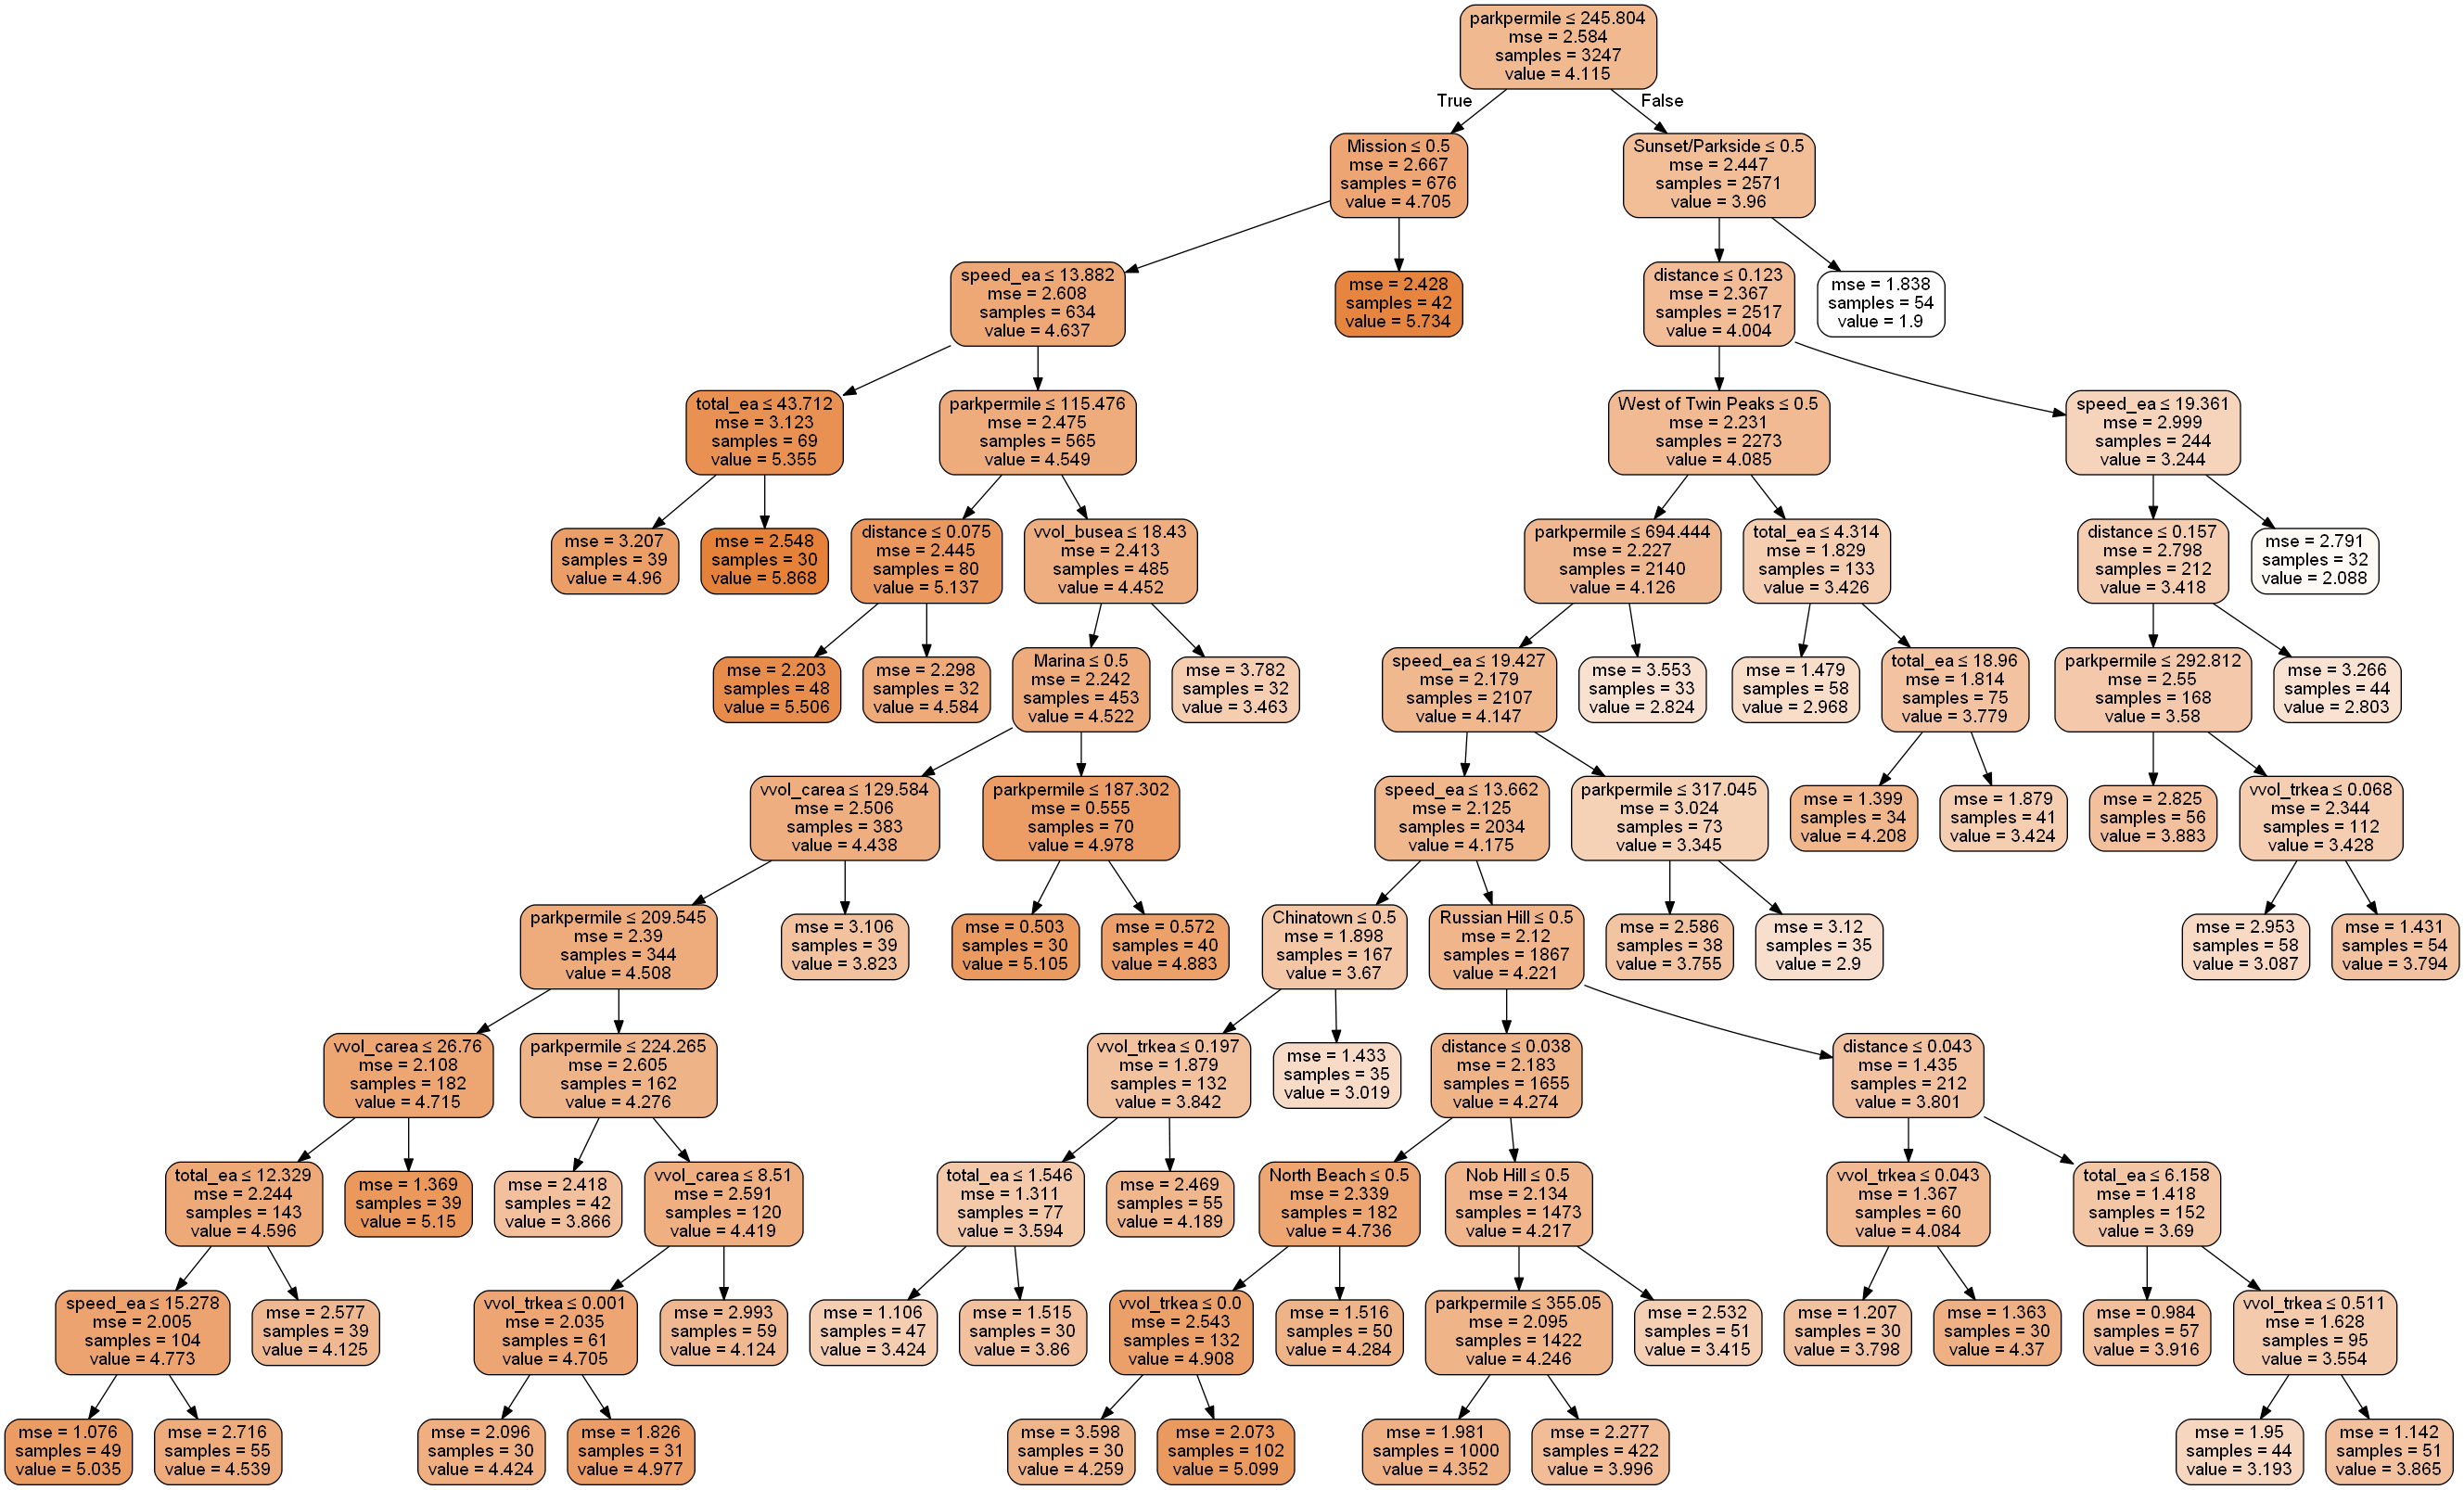

In [18]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

dtr = DecisionTreeRegressor(min_samples_leaf = 30, max_depth = 11)
dtr.fit(Xtr, Ytr)
predictors = predictors + nhoods.columns.tolist()

dot_data = StringIO()
export_graphviz(dtr, out_file='nhoodTree.dot', 
                filled=True, rounded=True,
                feature_names = predictors, 
                special_characters=True)
!dot -Tpng nhoodTree.dot -o nhoodtree.png

from IPython.display import Image
Image(filename='nhoodtree.png') 

In [19]:
featuredict = return_change(dtr)
for i in featuredict.keys():
    print("{} had an importance of {:.2f} and a mean avg decrease of {:.2f} ".format(predictors[i], dtr.feature_importances_[i] ,featuredict[i].mean() ))

parkpermile had an importance of 0.30 and a mean avg decrease of 1.15 
Mission had an importance of 0.03 and a mean avg decrease of 0.81 
speed_ea had an importance of 0.12 and a mean avg decrease of 1.21 
total_ea had an importance of 0.04 and a mean avg decrease of 1.00 
distance had an importance of 0.15 and a mean avg decrease of 1.19 
vvol_busea had an importance of 0.02 and a mean avg decrease of 1.31 
Marina had an importance of 0.01 and a mean avg decrease of 0.89 
vvol_carea had an importance of 0.02 and a mean avg decrease of 1.07 
vvol_trkea had an importance of 0.04 and a mean avg decrease of 0.85 
Sunset/Parkside had an importance of 0.15 and a mean avg decrease of 2.11 
West of Twin Peaks had an importance of 0.04 and a mean avg decrease of 1.20 
Chinatown had an importance of 0.01 and a mean avg decrease of 1.27 
Russian Hill had an importance of 0.03 and a mean avg decrease of 1.12 
North Beach had an importance of 0.01 and a mean avg decrease of 1.15 
Nob Hill had an i

parkpermile had an importance of 0.30 and a mean avg decrease of 1.15 
Mission had an importance of 0.03 and a mean avg decrease of 0.81 
speed_ea had an importance of 0.12 and a mean avg decrease of 1.21 
total_ea had an importance of 0.04 and a mean avg decrease of 1.00 
distance had an importance of 0.15 and a mean avg decrease of 1.19 
vvol_busea had an importance of 0.02 and a mean avg decrease of 1.31 
Marina had an importance of 0.01 and a mean avg decrease of 0.89 
vvol_carea had an importance of 0.02 and a mean avg decrease of 1.07 
vvol_trkea had an importance of 0.04 and a mean avg decrease of 0.85 
Sunset/Parkside had an importance of 0.15 and a mean avg decrease of 2.11 
West of Twin Peaks had an importance of 0.04 and a mean avg decrease of 1.20 
Chinatown had an importance of 0.01 and a mean avg decrease of 1.27 
Russian Hill had an importance of 0.03 and a mean avg decrease of 1.12 
North Beach had an importance of 0.01 and a mean avg decrease of 1.15 
Nob Hill had an i

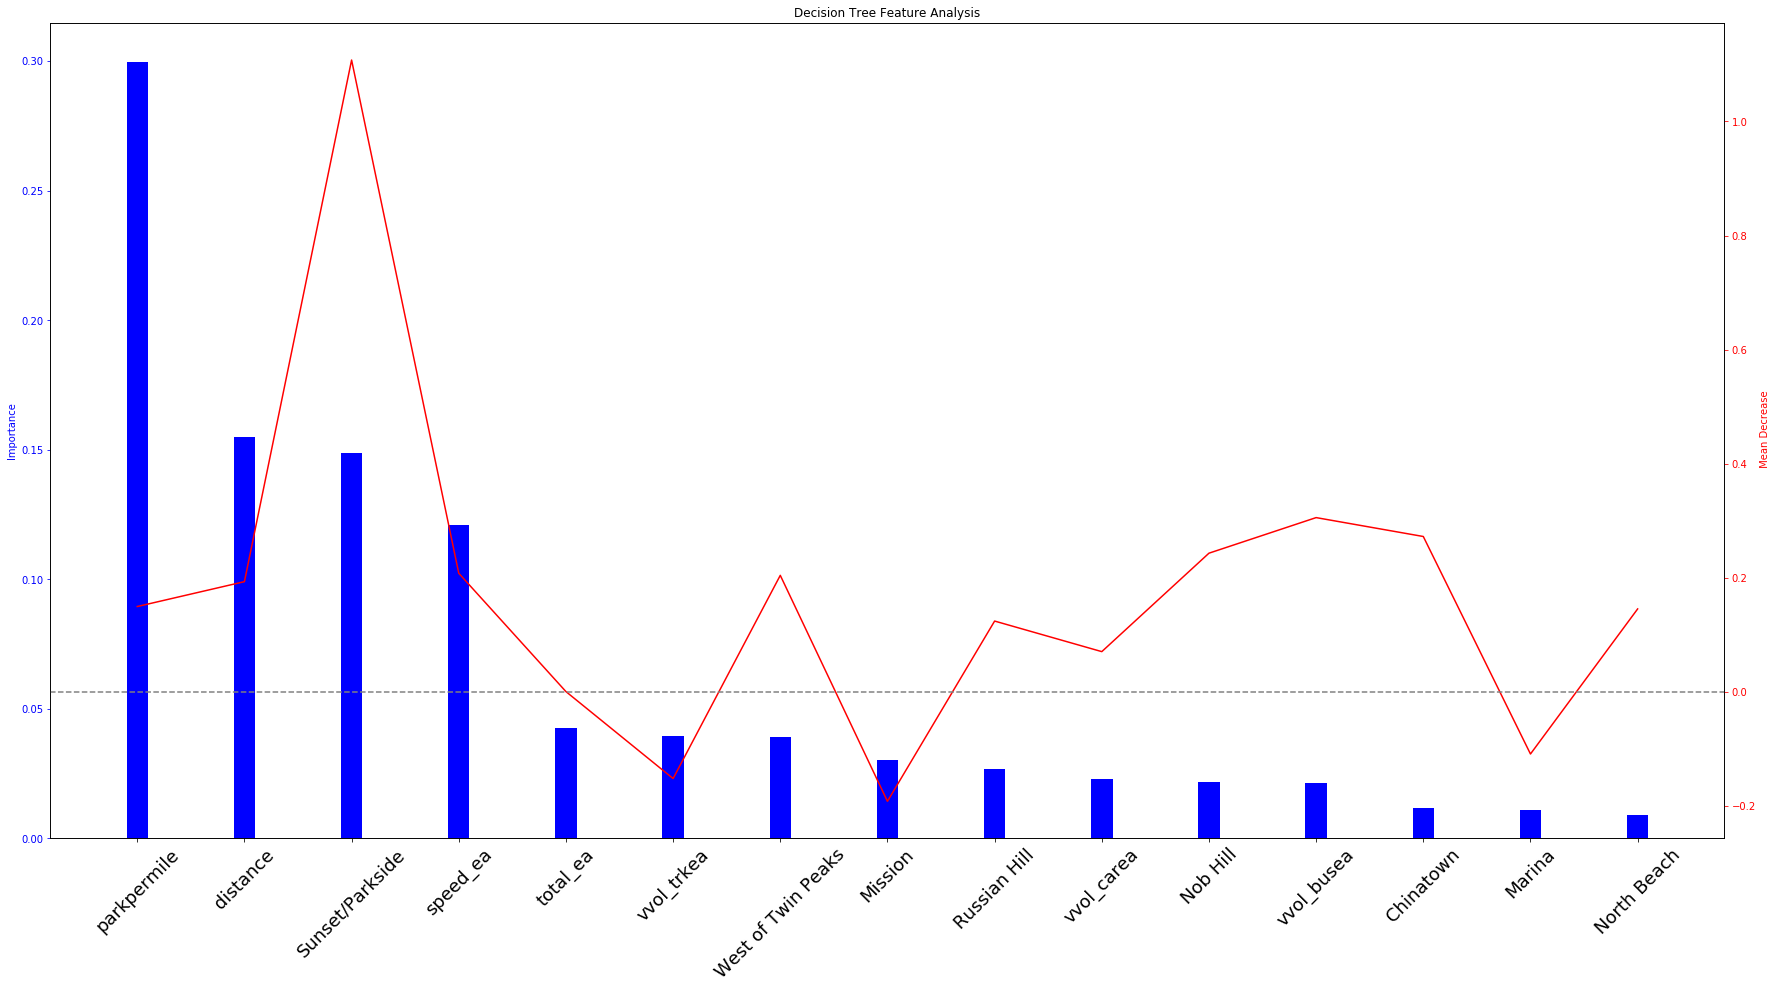

In [20]:
featdf = create_df(featuredict)
featdf['decrease'] = featdf['decrease'] - 1
ax = plot_features(featdf)
ax.set_xticklabels(featdf['feature'],  {'fontsize': 18, 'rotation' : 45})
ax.set_labels()
plt.savefig('nhoodfeature.png')

In [21]:
Xts = Xts.join(nhoods)
Ypr = dtr.predict(Xts)
print(((Ypr - Yts)**2).mean(axis = None))
print(((Ypr - Yts)**2).mean(axis = None) / Yts.mean())
print(r2_score(Yts, Ypr))

2.3679135012953605
0.5847406175103972
0.0764631463816805


So, the difference between our very large tree and a simple neighborhood classifier is negligible...let's try a random forest. 

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(random_state = 42)
param_grid = {'n_estimators': [50,100,200,250],'min_samples_leaf':np.arange(10,150,10), 'max_depth': np.arange(1,15)}



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
reg = GridSearchCV(rfr, param_grid, cv = 4, return_train_score = True, scoring = scoring)
reg.fit(Xtr, Ytr)
pd.DataFrame(reg.cv_results_).sort_values(by = 'mean_test_score', ascending = False)[['params','mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
729,"{'max_depth': 14, 'min_samples_leaf': 10, 'n_e...",0.326359,0.166288
728,"{'max_depth': 14, 'min_samples_leaf': 10, 'n_e...",0.324659,0.165964
731,"{'max_depth': 14, 'min_samples_leaf': 10, 'n_e...",0.328694,0.165749
730,"{'max_depth': 14, 'min_samples_leaf': 10, 'n_e...",0.328381,0.165589
673,"{'max_depth': 13, 'min_samples_leaf': 10, 'n_e...",0.314667,0.164185


In [24]:
best_params = reg.best_params_

In [25]:
rf = RandomForestRegressor(n_estimators = best_params['n_estimators'], min_samples_leaf = best_params['min_samples_leaf'], max_depth = best_params['max_depth'], random_state = 42)
rf.fit(Xtr, Ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
feature_imp = {}
feature_imp['feature'] = []
feature_imp['importance'] = []
for i, p in enumerate(predictors):
    print('Predictor {} had  an importance of {:.2f}'.format(p, rf.feature_importances_[i]))
    feature_imp['feature'].append(p)
    feature_imp['importance'].append(rf.feature_importances_[i])

rfdf = pd.DataFrame.from_dict(feature_imp)

Predictor distance had  an importance of 0.16
Predictor total_ea had  an importance of 0.06
Predictor vvol_carea had  an importance of 0.06
Predictor vvol_trkea had  an importance of 0.08
Predictor vvol_busea had  an importance of 0.04
Predictor speed_ea had  an importance of 0.09
Predictor oneway had  an importance of 0.00
Predictor parkpermile had  an importance of 0.23
Predictor Bayview Hunters Point had  an importance of 0.00
Predictor Bernal Heights had  an importance of 0.02
Predictor Castro/Upper Market had  an importance of 0.00
Predictor Chinatown had  an importance of 0.01
Predictor Excelsior had  an importance of 0.00
Predictor Financial District/South Beach had  an importance of 0.02
Predictor Glen Park had  an importance of 0.00
Predictor Golden Gate Park had  an importance of 0.00
Predictor Haight Ashbury had  an importance of 0.01
Predictor Hayes Valley had  an importance of 0.01
Predictor Inner Richmond had  an importance of 0.00
Predictor Inner Sunset had  an importanc

In [27]:
Ypr = rf.predict(Xts)
print(((Ypr - Yts)**2).mean(axis = None))
print(((Ypr - Yts)**2).mean(axis = None) / Yts.mean())
print(r2_score(Yts, Ypr))

2.2022063028562355
0.543820318061872
0.14109249394216283


In [28]:
rfdf.sort_values(by = 'importance', ascending = False, inplace = True)
rfdf.set_index('feature')[:15]

,importance
feature,
parkpermile,0.228304
distance,0.159665
speed_ea,0.089639
vvol_trkea,0.083324
Sunset/Parkside,0.079377
total_ea,0.059913
vvol_carea,0.055229
vvol_busea,0.044185
West of Twin Peaks,0.029997


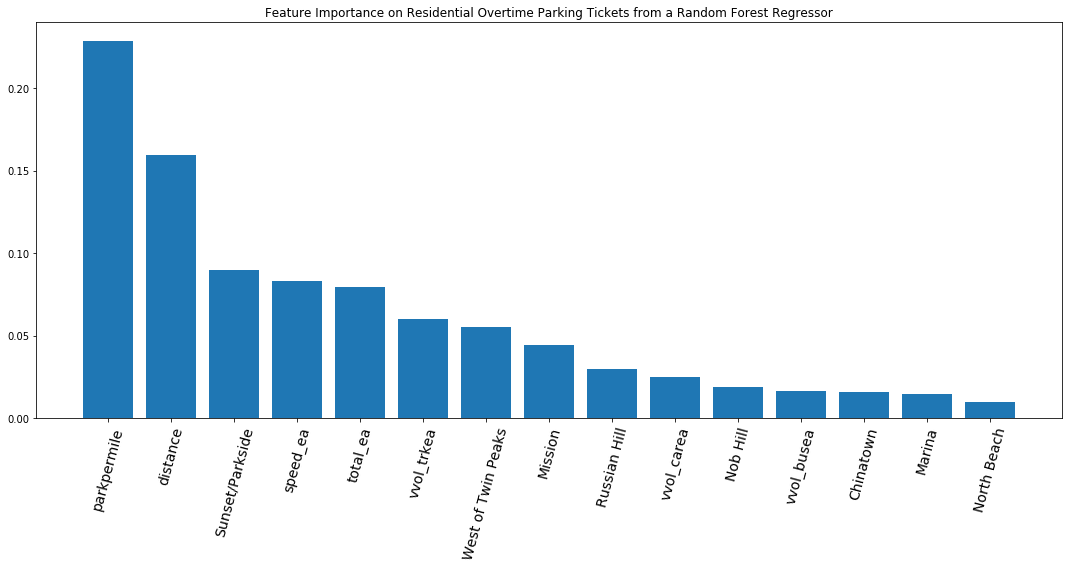

In [44]:
fig, ax = plt.subplots(figsize = (15, 8))
plt.bar(rfdf['feature'][:15], rfdf['importance'][:15])
ax.set_xticklabels(featdf['feature'],  {'fontsize': 14, 'rotation' : 75})
plt.title('Feature Importance on Residential Overtime Parking Tickets from a Random Forest Regressor')
plt.tight_layout()
plt.savefig('rfrfeat.png')